In [137]:
## Imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
## Settings
tf.random.set_seed(42)
np.random.seed(42)
AU = 147095000000.
ED = 86400.

In [139]:
@tf.function
def pairwise_distances(X: tf.Tensor) -> tf.Tensor:
    # r = tf.reduce_sum(X * X, 1)
    # r = tf.reshape(r, [-1, 1])
    # D = r - 2.*tf.matmul(X, tf.transpose(X)) + tf.transpose(r)
    return tf.expand_dims(X, axis=0) - tf.expand_dims(X, axis=1)

@tf.function
def acceleration(Q: tf.Tensor, M: tf.Tensor, G: float = 6.67430e-11 / 149597870700.**3. * 86400.**2. * 1.98847e30) -> tf.Tensor:

    ## Calculating Pairwise Distances
    D = pairwise_distances(Q[:, :3])

    ## Masking and reshaping X and M to drop self-differences:
    mask_reps = int(D.shape[0])
    mask_len = int(mask_reps*mask_reps)
    D = tf.reshape(D, (-1, 3))
    mask = tf.tile([False] + (mask_reps)*[True], [mask_reps])[:mask_len] ## Would be optimal to store as constant in a class.
    D = tf.boolean_mask(D, mask, axis=0)

    D = tf.reshape(D, (mask_reps, (mask_reps-1), -1))

    # print("Distance")
    # print(D)

    M = tf.tile(M, [mask_reps])
    M = tf.reshape(M, (-1, 1))
    M = tf.boolean_mask(M, mask, axis=0)
    M = tf.reshape(M, (mask_reps, -1, 1))

    # print("Masses")
    # print(M)

    ## Calculating |xi-xj|^(-3)
    d_inv_cube = tf.pow(tf.reduce_sum(D*D, axis=-1, keepdims=True) + 1e-2, -3./2.) # 1e-10 to smooth numerical overflow

    # print("|D|^{-3}")
    # print(d_inv_cube)
    
    ## Calculating pairwise Force
    F = M * D * d_inv_cube

    ## Summation over each other body
    F = G * tf.reduce_sum(F, axis=1)

    # print("Force")
    # print(F)

    ## Combining to R6 acceleration
    dQ = tf.concat([Q[:, 3:], F], axis=-1)
    
    return dQ

def return_ode_fn(M):
    @tf.function
    def ode_fn(Q):
        return acceleration(Q, M)
    return ode_fn


In [140]:
30300./AU*ED

0.017797477820456167

In [141]:
Q0 = tf.Variable([
    [0., 0., 0., 0., 0., 0.], 
    [1., 0., 0., 0., 30300./AU*ED, 0.], # Earth
    [0., 1.524, 0., 27070./AU*ED, 0., 0.], # Mars
    # [3., 0., 0., 0., 3.*30300./AU*ED, 0.]
])
M0 = tf.constant([
    1., 
    3.0025e-6, # Earth
    0.107 * 3.0025e-6, # Mars
    # 3.0025e-6
])
print(Q0)
print(M0)

<tf.Variable 'Variable:0' shape=(3, 6) dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.01779748,
        0.        ],
       [0.        , 1.524     , 0.        , 0.01590025, 0.        ,
        0.        ]], dtype=float32)>
tf.Tensor([1.000000e+00 3.002500e-06 3.212675e-07], shape=(3,), dtype=float32)


In [142]:
N_init = 1000
X0 = tf.random.normal(shape=(N_init, 3), mean=0, stddev=10., dtype=tf.float64)
V0 = tf.random.normal(shape=(N_init, 3), mean=0., stddev=0.05, dtype=tf.float64)
Q0 = tf.concat([X0, V0], axis=1)
Q0 = tf.Variable(Q0)
# print(Q0)
M0 = tf.constant(np.random.chisquare(df=1, size=N_init), dtype=tf.float64)
# print(M0)

In [143]:
# Q0 = tf.Variable([
#     [ 1., 0., 0., 0., 0.01, 0.],
#     [-1., 0., 0., 0., -0.01, 0.]
# ], dtype=tf.float64)
# print(Q0)
# M0 = tf.constant(2*[1.], dtype=tf.float64)
# print(M0)

In [144]:
# acceleration(Q0, M0)

## Runge Kutta Fehlberg integrator for the equations of Motion

The Runge-Kutte-Fehlberg Method is a numerical Method for integrating ordinary differential equations. The following implementation is meant to integrate equations of motion with the acceleration `f`.

In [145]:
@tf.function
def solver_rkf(Q, dt, f):
    k1 = f(Q)
    k2 = f(Q + dt * k1 / 4.)
    k3 = f(Q + dt * k1 * 3. / 32.      + dt * k2 * 9. / 32.)
    k4 = f(Q + dt * k1 * 1932. / 2197. - dt * k2 * 7200. / 2197. + dt * k3 * 7296. / 2197.)
    k5 = f(Q + dt * k1 * 439. / 216.   - dt * k2 * 8.            + dt * k3 * 3680. / 513   - dt * k4 * 845. / 4104.)
    k6 = f(Q - dt * k1 * 8. / 27.      + dt * k2 * 2.            - dt * k3 * 3544. / 2565. + dt * k4 * 1859. / 4104. - dt * k5 * 11. / 40.)
    Q = Q + dt * (16. / 135. * k1 + 6656. / 12825. * k3 + 28561. / 56430. * k4 - 9. / 50. * k5 + 2. / 55. * k6)
    return Q

## First Test

In [146]:
ode_fn = return_ode_fn(M0)

Q = Q0
dt = 1
Q_hist = [Q]
n_years = 10

for k in range(n_years*365):
    Q = solver_rkf(Q, dt, ode_fn)
    Q_hist = tf.concat([Q_hist, [Q]], axis=0)

# Q_hist[:2]

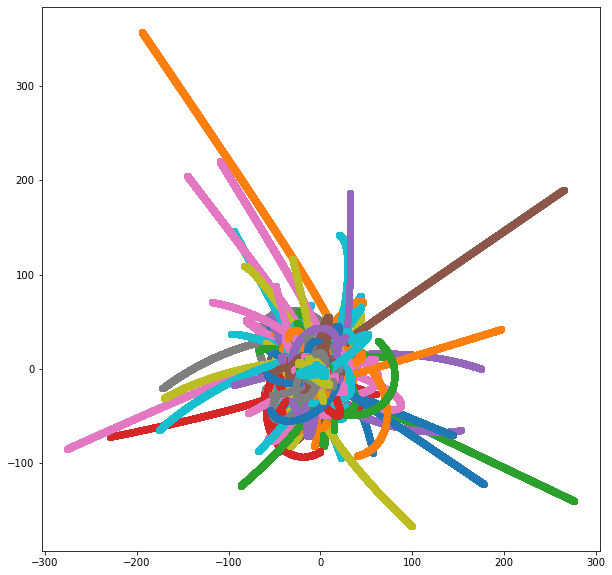

In [149]:
plt.figure(figsize=(10, 10))
for n in range(Q_hist.shape[1]):
    plt.scatter(Q_hist[:, n, 0], Q_hist[:, n, 1])
# plt.scatter(Q_hist[:, 0, 0], Q_hist[:, 0, 1])
plt.show()